<a href="https://colab.research.google.com/github/TaylorShiehUSI/Github-Colab-test/blob/main/20220814_2230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [51]:
# 下載資料套件
import requests as r

# 資料處理套件
from lxml import etree
import json
from datetime import datetime, date
import pandas as pd

# 財經套件
# import yfinance as yf

# 畫圖套件
import plotly.graph_objects as go

In [52]:
## down load stock data
def get_tw_stock_data(start_year, start_month, end_year, end_month, stock_code):
    start_date = str(date(start_year, start_month, 1))
    end_date = str(date(end_year, end_month, 1))
    month_list = pd.date_range(start_date, end_date, freq='MS').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for month in month_list:
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo=" + str(stock_code)
        res = r.get(url)
        stock_json = res.json()
        stock_df = pd.DataFrame.from_dict(stock_json['data'])
        df = df.append(stock_df, ignore_index = True)
        
    # 資料轉型
    for col in [0, 1, 2, 3, 4, 5, 6, 8]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)，並將民國年換成西元年
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]) + 1911, int(day[1]), int(day[2]))  
            # 把"開盤價", "最高價", "最低價", "收盤價"帶有逗號的字串(string)換成浮點數(float) 
            elif col != 0:
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    df.columns = ['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']
    return df

In [53]:
##  input Start - End , and stock index
stock_df = get_tw_stock_data(start_year = 2021, 
                start_month = 1, 
                end_year = 2022, 
                end_month = 8, 
                stock_code = 2330)
stock_df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2021-01-04 00:00:00,39489959.0,21127581248.0,530.0,540.0,528.0,536.0,+6.00,33316.0
1,2021-01-05 00:00:00,34839391.0,18761831567.0,536.0,542.0,535.0,542.0,+6.00,28512.0
2,2021-01-06 00:00:00,55614434.0,30572783229.0,555.0,555.0,541.0,549.0,+7.00,55462.0
3,2021-01-07 00:00:00,53392763.0,30018630685.0,554.0,570.0,553.0,565.0,+16.00,47905.0
4,2021-01-08 00:00:00,62957148.0,36339702855.0,580.0,580.0,571.0,580.0,+15.00,56426.0
...,...,...,...,...,...,...,...,...,...
392,2022-08-15 00:00:00,22519886.0,11755494600.0,520.0,524.0,519.0,523.0,+6.00,27372.0
393,2022-08-16 00:00:00,21234122.0,11141160337.0,526.0,526.0,523.0,525.0,+2.00,20628.0
394,2022-08-17 00:00:00,28461939.0,14943047011.0,524.0,527.0,521.0,527.0,+2.00,26466.0
395,2022-08-18 00:00:00,18721898.0,9734756997.0,520.0,521.0,519.0,520.0,-7.00,24209.0


In [57]:
## Save 2230 stock data to CSV
stock_df.to_csv('2230.csv',encoding='utf-8_sig')

In [58]:
## Data Processing // Add is_up, (高低差，漲跌價差，單筆股數)，特徵
import numpy as np

stock_df['is_up'] = (stock_df['開盤價'].shift(-1) - stock_df['收盤價'] >0).astype('int')
stock_df['高低差'] = (stock_df['最高價'] - stock_df['最低價']).astype('int')
stock_df['漲跌價差'] = (stock_df['收盤價'] - stock_df['開盤價']).astype('int')
stock_df['單筆股數'] = (stock_df['成交股數']/stock_df['成交筆數']).astype('int')

## One Hot code for is_up 
def one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]
y_data = one_hot(stock_df['is_up'], 2)

## 2230 Stock_df check
stock_df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,is_up,高低差,單筆股數
0,2021-01-04 00:00:00,39489959.0,21127581248.0,530.0,540.0,528.0,536.0,6,33316.0,0,12,1185
1,2021-01-05 00:00:00,34839391.0,18761831567.0,536.0,542.0,535.0,542.0,6,28512.0,1,7,1221
2,2021-01-06 00:00:00,55614434.0,30572783229.0,555.0,555.0,541.0,549.0,-6,55462.0,1,14,1002
3,2021-01-07 00:00:00,53392763.0,30018630685.0,554.0,570.0,553.0,565.0,11,47905.0,1,17,1114
4,2021-01-08 00:00:00,62957148.0,36339702855.0,580.0,580.0,571.0,580.0,0,56426.0,0,9,1115


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38989 missing from current font.
  

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25104 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_te

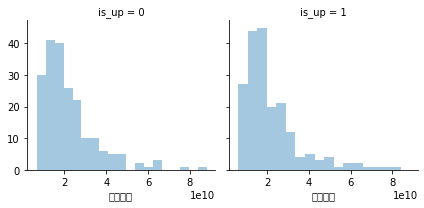

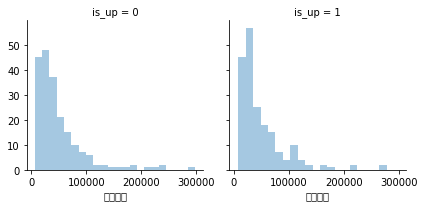

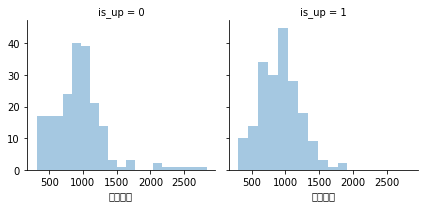

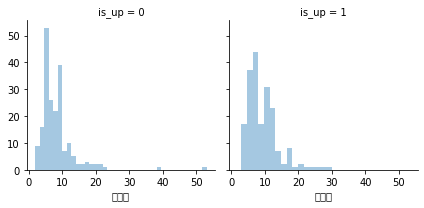

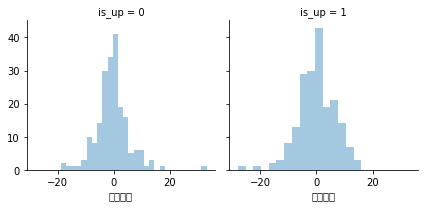

In [60]:
# Stock Data Exploring
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None

g = sns.FacetGrid(stock_df, col='is_up')
g.map(sns.distplot, '成交金額',kde=False )

g = sns.FacetGrid(stock_df, col='is_up')
g.map(sns.distplot, '成交筆數',kde=False )

g = sns.FacetGrid(stock_df, col='is_up')
g.map(sns.distplot, '單筆股數',kde=False )

g = sns.FacetGrid(stock_df, col='is_up')
g.map(sns.distplot, '高低差', kde=False)

g = sns.FacetGrid(stock_df, col='is_up')
g.map(sns.distplot, '漲跌價差', kde=False)

## Feature Engineering
# ##group = data.groupby("company")
# ##list(group)
# ##data.groupby("company").agg('mean')
# ##data.groupby('company').agg({'salary':'median','age':'mean'})
# ##avg_salary_dict = data.groupby('company')['salary'].mean().to_dict()
# ​##data['avg_salary'] = data['company'].map(avg_salary_dict)

# group1 = stock_df.groupby("is_up").agg({'成交股數':'mean'})
# print(group1)

# group2 = stock_df.groupby("is_up").agg({'成交金額':'mean'})
# print(group2)

# # As feature
# group3 = stock_df.groupby("is_up").agg({'漲跌價差':'mean'})
# print(group3)

# # As feature
# group4 = stock_df.groupby("is_up").agg({'高低差':'mean'})
# print(group4)

# # As feature
# group5 = stock_df.groupby("is_up").agg({'單筆股數':'mean'})
# print(group5)

# group6 = stock_df.groupby("is_up").agg({'成交筆數':'mean'})
# print(group6)

# group7 = stock_df.groupby("is_up").agg({'收盤價':'mean'})
# print(group7)
# ## data.groupby("company").agg('mean')
# ## data.groupby('company').agg({'salary':'median','age':'mean'})
# ## avg_salary_dict = data.groupby('company')['salary'].mean().to_dict()
# ​## data['avg_salary'] = data['company'].map(avg_salary_dict)
# ## Prepare Feature Data


In [ ]:
## try to implement code, check Fisher Score, but don't finish
# data = pd.read_csv('data/data1to21.csv', header=None)

# data[52] = data[52].astype(int).data

# # # 計算fisher得分
# items = list(range(52))

# num_classes = len(set(data[52]))

# fisher_score = []

# grouped = data.groupby([52], as_index=False)

# n = [len(data[data[52] == k+1]) for k in range(num_classes)]

# for i in items:  # 遍歷所有特徵列
#     temp = grouped[i].agg({str(i)+'_mean': 'mean',
#                            str(i)+'_std': 'std'})     # 已求出特徵i在各類別k中的均值u_ik、方差p_ik

#     numerator = 0
#     denominator = 0

#     u_i = data[i].mean()

#     for k in range(num_classes):
#         n_k = n[k]
#         u_ik = temp.iloc[k, :][str(i)+'_mean']
#         p_ik = temp.iloc[k, :][str(i)+'_std']

#         numerator += n_k*(u_ik-u_i)**2
#         denominator += n_k*p_ik**2

#     fisher_score.append(numerator/denominator)

# pd.DataFrame(fisher_score).to_csv('fisher_score.csv', index=False, header=None)

In [61]:
## Drop Day and is_up, to prepare RAW 2230 stock data for Trainng
X_data = stock_df.drop(['日期','is_up'], axis=1)
X_data.head()
X_data.columns

Index(['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', '高低差',
       '單筆股數'],
      dtype='object')

In [62]:
## Normalized 2230 stock data in columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_data)
scaled = scaler.fit_transform(X_data)
X_data = pd.DataFrame(scaled, columns=X_data.columns)
#print(X_data)
X_data.head()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,高低差,單筆股數
0,0.082927,-0.068866,-1.148434,-1.014559,-1.091790,-1.007840,1.014957,-0.376955,0.623192,0.722419
1,-0.131292,-0.244964,-1.014348,-0.969875,-0.934200,-0.873616,1.014957,-0.485475,-0.379268,0.824338
2,0.825670,0.634200,-0.589740,-0.679430,-0.799122,-0.717020,-0.907609,0.123314,1.024176,0.204335
3,0.723333,0.592951,-0.612087,-0.344302,-0.528968,-0.359088,1.816026,-0.047396,1.625652,0.521414
4,1.163898,1.063469,-0.031045,-0.120883,-0.123736,-0.023526,0.053674,0.145090,0.021716,0.524245


In [63]:
## train the model, with preparing the data
from sklearn.model_selection import train_test_split
from keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# keep one hot Encoding in y for Cross Table
y_test_cross = y_test
y_test_cross = np.argmax(y_test_cross,axis=1)
print(y_test_cross)
# print(y_test_cross)

X_train = K.cast_to_floatx(X_train)
y_train = K.cast_to_floatx(y_train)
X_test = K.cast_to_floatx(X_test)
y_test = K.cast_to_floatx(y_test)

[0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1
 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0
 0 1 0 1 1 1]


In [66]:
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

## set up model, and print the model summary
model = Sequential()
model.add(Dense(units = 128,
                input_shape=X_train.shape[1:],
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 8,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units = 8,
                kernel_initializer = 'normal',
                activation='relu'))

model.add(Dense(units = 2,
                kernel_initializer = 'normal',
                activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               1408      
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 8)                 1032      
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_44 (Dense)            (None, 8)                 72        
                                                                 
 dense_45 (Dense)            (None, 2)                 18        
                                                                 
Total params: 2,530
Trainable params: 2,530
Non-train

In [67]:
## train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.fit(x = X_train,
          y = y_train,
          validation_split = 0.2,
          batch_size=128,
          epochs=1000,
          verbose = 2) 

Epoch 1/1000
2/2 - 1s - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6928 - val_accuracy: 0.5938 - 981ms/epoch - 490ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6931 - accuracy: 0.5178 - val_loss: 0.6926 - val_accuracy: 0.5938 - 33ms/epoch - 16ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6930 - accuracy: 0.5138 - val_loss: 0.6924 - val_accuracy: 0.5938 - 33ms/epoch - 16ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6930 - accuracy: 0.5178 - val_loss: 0.6923 - val_accuracy: 0.5938 - 37ms/epoch - 18ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6931 - accuracy: 0.5099 - val_loss: 0.6921 - val_accuracy: 0.5938 - 35ms/epoch - 18ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.6930 - accuracy: 0.5138 - val_loss: 0.6919 - val_accuracy: 0.5938 - 37ms/epoch - 18ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.6929 - accuracy: 0.5138 - val_loss: 0.6918 - val_accuracy: 0.5938 - 32ms/epoch - 16ms/step
Epoch 8/1000
2/2 - 0s - loss: 0.6928 - accuracy: 0.5138 - val_loss: 0.6916 - val_accuracy: 0.5938 - 37ms/epoch - 19ms/step
Epoch 9/1000
2

In [68]:
## Evalaute evaluate Accury, and print out
score = model.evaluate(X_test, y_test, verbose=1)
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(score[1]*100.0)) 
#print('score', score)

3/3 [==============================] - 0s 6ms/step - loss: 0.7443 - accuracy: 0.5625

	[Info] Accuracy of testing data = 56.2%


In [70]:
# 預測(prediction)
# X = X_test[0:20,:]
# #predictions = model.predict_classes(X)
# mypredictions = model.predict(X).astype('int64')
# classes_x = np.argmax(mypredictions, axis = 1)
# classes_x

#myPredict = model.predict_classes( X_test).astype('int64')
myPredict=model.predict(X_test).astype('int64') 
classes_x=np.argmax(myPredict,axis=1)
#print(classes_x)
#classes_x

In [71]:
#y_test
#混淆矩陣 (confusion matrix)  -> cross table
print(y_test_cross)
print(classes_x)
pd.crosstab(y_test_cross,classes_x)


[0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1
 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0
 0 1 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


col_0,0
row_0,
0,35
1,45


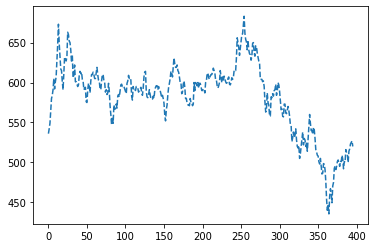

In [ ]:
# from matplotlib import pyplot as plt
# plt.plot( stock_df['收盤價'], '--')
# plt.show()
